In [3]:
import os
from standardiser import standardise
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
import numpy as np
import umap
import seaborn as sns
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


DATAPATH = "../data"

In [11]:
grover = pd.read_csv(os.path.join(DATAPATH, "reference_library.csv"))
coconut = PandasTools.LoadSDF(os.path.join(DATAPATH, "COCONUT_DB.SDF"))

[07:01:37] Explicit valence for atom # 20 C, 6, is greater than permitted
[07:01:37] ERROR: Could not sanitize molecule ending on line 53
[07:01:37] ERROR: Explicit valence for atom # 20 C, 6, is greater than permitted
[07:01:38] ERROR: EOF hit while reading bonds
[07:01:38] ERROR: moving to the beginning of the next molecule


In [12]:
def is_processable_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            return True
        else:
            return False
    except Exception as e:
        print("Error:", e)
        return False

In [13]:
def get_inchikey(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    else:
        # Generate InChIKey
        inchi_key = Chem.InchiToInchiKey(Chem.MolToInchi(mol))

        return inchi_key

In [14]:
def canonical_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    else:
        # Generate canonical SMILES
        canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=False)

        return canonical_smiles

In [15]:
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)

    if mol is not None:
        try:
            mol = standardise.run(mol)  # standardise.run expects a list of molecules
        except:
            mol = None

    if mol is not None:
        smiles_standard = Chem.MolToSmiles(mol)
    else:
        smiles_standard = None

    return smiles_standard

# Data gotten from Grover

In [16]:
grover['validate_smiles'] = grover['smiles'].apply(lambda x: is_processable_smiles(x))
grover[grover['validate_smiles']]

[07:03:41] SMILES Parse Error: extra open parentheses for input: 'COC1=CC=CC(CC(=O)N2CCC3=NC'


,smiles,validate_smiles
0,COC(=O)C1=CC=CC2=C1C(=O)C1=CC([N+](=O)[O-])=CC...,True
1,CN(C)CCC1=CN(C)C2=CC=C(O)C=C12,True
2,CC1=C(S(=O)(=O)N2CCCCC2)C2=C(S1)N=CN(CC(=O)N1C...,True
3,CN(C)CCOC1=CC=C(C(=O)/C=C/C2=CC=C(OC3=CC=CC=C3...,True
4,O=C(CCC1=COC2=CC=CC(OCC3CCCCC3)=C2C1=O)C1=CC=C...,True
...,...,...
523903,C1=CC=C2C(N3CCC4(CCCCC4)CC3)=CN=CC2=C1,True
523904,FC(F)(F)C1=CC=C(C2=C(CNCCC3=CC=C(Cl)C(Cl)=C3)N...,True
523905,C[C@H](NP(=O)(O)CCCCC1=CC=CC=C1)C(=O)N1CCC[C@H...,True
523906,CCCCCCCCCCCCCCC(=O)OCC(=O)NCC1=CC(OC)=C(O)C=C1I,True


In [17]:
# Randomly choose 800 SMILES
sampled_df = grover.sample(n=1000, random_state=42)

In [18]:
# Apply the canonical_smiles function to obtain their canonical smiles
grover_smiles = sampled_df.apply(lambda row: pd.Series(canonical_smiles(row['smiles']), index=['Canonical_SMILES']), axis=1)
grover = pd.concat([sampled_df, grover_smiles], axis=1)
#Standardise the smiles
grover['Standardized_SMILES'] = grover['Canonical_SMILES'].apply(standardize_smiles)
grover_cleaned = grover.dropna()
print(grover_cleaned)

[07:03:53] Can't kekulize mol.  Unkekulized atoms: 3 9


                                                   smiles  validate_smiles  \
365181  O=C(O)CC1CCC(C2=CC=C(C3=CN4C=C(C(=O)NCC5=CC=C(...             True   
477752  COC1=CC=C(C2CC23CCCC2(CC2C2=CC=C(OC)C(OC)=C2)C...             True   
300726  NC1=CC2=C(C3=CC=C(S(=O)(=O)NCCO)C=C13)C(CCl)CN...             True   
97323            COC1=CC=C2C(=C1)N=C(O)C1=C2C2=CC=CC=C2S1             True   
302007         COC(=O)CCNC(=O)/C=C/C1=C(Cl)C2=CC=CC=C2CC1             True   
...                                                   ...              ...   
370988      O=C(NC1=CC=CC(NC(=O)C2=CC=CS2)=C1)C1=CC=CC=C1             True   
509001     COC1=CC=C(CCCN2CCC(COCC3=CC=C(Cl)C=C3)CC2)C=C1             True   
371690       O=C(NCCC1=CC=C(OCCN2CCCC2)C(Br)=C1)C1=CC=CN1             True   
470244  O=C(C1CCC1)N1CCN(C2=NC(=O)C3=CC(C(F)(F)F)=CC([...             True   
51269   COC(=O)C1=C(O)C=CC2=C1C1=CC3=CC=CC=C3C=C1N2CC1...             True   

                                         Canonical_SMILES  \
36

In [19]:
grover = grover_cleaned.sample(n=800, random_state=42)
grover.drop(columns=['validate_smiles'], inplace=True)
grover_smiles = grover.apply(lambda row: pd.Series(get_inchikey(row['smiles']), index=['InChIKey']), axis=1)
grover = pd.concat([grover, grover_smiles], axis=1)
grover['Data'] = 'Chembl'

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Proton(s) added/removed

[07:03:56] WARNING: Omitted undefined stereo; Proton(s) added/removed

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56] WARNING: Omitted undefined stereo

[07:03:56]

In [21]:
grover
grover.to_csv(os.path.join(DATAPATH, 'grover.csv'), index=False)

# Data gotten from Coconut

In [22]:
coconut.rename(columns={'inchikey': 'InChIKey'}, inplace=True)
coconut.rename(columns={'SMILES': 'smiles'}, inplace=True)
coconut['validate_smiles'] = coconut['smiles'].apply(lambda x: is_processable_smiles(x))
coconut[coconut['validate_smiles']]

,coconut_id,inchi,InChIKey,smiles,sugar_free_smiles,molecular_formula,molecular_weight,citationDOI,textTaxa,name,...,total_atom_number,bond_count,found_in_databases,murko_framework,alogp,apol,topoPSA,ID,ROMol,validate_smiles
1,CNP0000002,InChI=1S/C27H36N2O15S/c1-5-12(29-9-45)26(37)44...,FJEMIESGEMWDOB-UHFFFAOYSA-N,O=C(O)C=1C(=O)C(O)(CC(=O)C1N)C2OC(COC(=O)C)C(O...,O=C(O)C=1C(=O)C(O)CC(=O)C1N,C27H36N2O15S,660.6463016716552,[],[notax],5-{6-[(acetyloxy)methyl]-3-hydroxy-4-[(5-hydro...,...,81,47,[chemspidernp],C1=CCCCC1,-2.4338000000000015,88.65454800000002,298.83,,<rdkit.Chem.rdchem.Mol object at 0x7f36d4502dc0>,True
2,CNP0000003,InChI=1S/C34H30O10/c1-14-10-16-24(21(11-14)42-...,KLWKJVYCDFWQMK-UHFFFAOYSA-N,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C(OC)=CC=C(OC)C6C...,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C(OC)=CC=C(OC)C6C...,C34H30O10,598.5972923812595,[],[notax],"20,30-dihydroxy-5,9,12,25-tetramethoxy-27-meth...",...,74,50,[chemspidernp],O1Cc2ccccc2CC34Cc5ccc6c(c5C4C=CCC13)Cc7ccccc7C6,0.027099999999997695,87.86379000000002,137.82,,<rdkit.Chem.rdchem.Mol object at 0x7f36d4502e30>,True
3,CNP0000004,InChI=1S/C32H26O9/c1-13-9-16-24(20(10-13)39-2)...,PTEKHLCNKCAXPH-UHFFFAOYSA-N,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,C32H26O9,554.5446526448111,[],[notax],"9,20,30-trihydroxy-5,25-dimethoxy-27-methyl-22...",...,67,47,[chemspidernp],O1Cc2ccccc2CC34Cc5ccc6c(c5C4C=CCC13)Cc7ccccc7C6,0.4611999999999999,80.874618,139.59,,<rdkit.Chem.rdchem.Mol object at 0x7f36d4502ea0>,True
4,CNP0000005,"InChI=1S/C33H42O6/c1-31(2,3)30(36)37-18-17-33(...",ZVAVQCZAGOKAMX-UHFFFAOYSA-N,O=C(OC1CC(C)(CCOC(=O)C(C)(C)C)C2CC(C)(C)CC2C1O...,O=C(OC1CC(C)(CCOC(=O)C(C)(C)C)C2CC(C)(C)CC2C1O...,C33H42O6,534.6842258201034,[],[notax],"5-(benzoyloxy)-7-{2-[(2,2-dimethylpropanoyl)ox...",...,81,42,[chemspidernp],O(Cc1ccccc1)C2CCC3CCCC3C2OCc4ccccc4,6.415000000000001,90.89730600000003,78.9,,<rdkit.Chem.rdchem.Mol object at 0x7f36d4502f10>,True
5,CNP0000006,InChI=1S/C31H24O9/c1-12-8-15-23(20(9-12)39-2)3...,UYIPOCQHTAYRMA-UHFFFAOYSA-N,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,C31H24O9,540.5180352403714,[],[notax],"5,9,20,30-tetrahydroxy-25-methoxy-27-methyl-22...",...,64,46,[chemspidernp],O1Cc2ccccc2CC34Cc5ccc6c(c5C4C=CCC13)Cc7ccccc7C6,0.39670000000000016,77.78103199999998,150.59,,<rdkit.Chem.rdchem.Mol object at 0x7f36d4502f80>,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,CNP0001827,InChI=1S/C61H114N2O21/c1-4-6-8-10-12-14-16-18-...,CNPPRLYZKHJIHM-UHFFFAOYSA-N,O=C(O)C1(OC2C(O)C(OC(CO)C2O)OC3C(O)C(O)C(OCC(N...,O=C(NC(CO)C(O)CCCCCCCCCCCCCCC)CCCCCCCCCCCCCCCCCCC,C61H114N2O21,1211.561045533237,[],[notax],"2-{[2-({4,5-dihydroxy-6-[(3-hydroxy-2-icosanam...",...,198,86,"[fooddb, pubchem]",O1CCCCC1,7.4617999999999975,202.41640199999986,373.41,,<rdkit.Chem.rdchem.Mol object at 0x7f36e1bac5f0>,True
1630,CNP0001828,InChI=1S/C59H108N2O21/c1-4-6-8-10-12-14-16-18-...,HLDHEAYPJCILAP-UHFFFAOYSA-N,O=C(O)C1(OC2C(O)C(OC(CO)C2O)OC3C(O)C(O)C(OCC(N...,O=C(NC(CO)C(O)CCCCCCCCCCCCCCC)CCCCCCCCCC=CCCCCCC,C59H108N2O21,1181.491929216706,[],[notax],"2-({2-[(4,5-dihydroxy-6-{[3-hydroxy-2-(octadec...",...,190,84,[fooddb],O1CCCCC1,6.104799999999991,194.89564399999992,373.41,,<rdkit.Chem.rdchem.Mol object at 0x7f36e1bac510>,True
1631,CNP0001829,InChI=1S/C59H110N2O21/c1-4-6-8-10-12-14-16-18-...,CFCULLUWKLQKFQ-UHFFFAOYSA-N,O=C(O)C1(OC2C(O)C(OC(CO)C2O)OC3C(O)C(O)C(OCC(N...,O=C(NC(CO)C(O)CCCCCCCCCCCCCCC)CCCCCCCCCCCCCCCCC,C59H110N2O21,1183.5078107243578,[],[notax],"2-{[2-({4,5-dihydroxy-6-[(3-hydroxy-2-octadeca...",...,192,84,"[fooddb, pubchem]",O1CCCCC1,6.549399999999992,196.2292299999999,373.41,,<rdkit.Chem.rdchem.Mol object at 0x7f36e1bac430>,True
1632,CNP0001830,InChI=1S/C57H106N2O21/c1-4-6-8-10-12-14-16-18-...,RBTPLAKLLKHEMT-UHFFFAOYSA-N,O=C(O)C1(OC2C(O)C(OC(CO)C2O)OC3C(O)C(O)C(OCC(N...,O=C(NC(CO)C(O)CCCCCCCCCCCCCCC)CCCCCCCCCCCCCCC,C57H106N2O21,1155.4545759154782,[],[no

In [ ]:
coconut = coconut[['InChIKey', 'smiles', 'molecular_weight']]
coconut
coconut.to_csv(os.path.join(DATAPATH, 'coconut_data.csv'), index=False)

In [24]:
data = pd.read_csv(os.path.join(DATAPATH, "coconut_data.csv"))

In [25]:
data['molecular_weight'] = data['molecular_weight'].astype(float)
filtered_data = data[data['molecular_weight'] <= 800]
filtered_data['validate_smiles'] = filtered_data['smiles'].apply(lambda x: is_processable_smiles(x))
data = filtered_data.apply(lambda row: pd.Series(canonical_smiles(row['smiles']), index=['Canonical_SMILES']), axis=1)
coconut = pd.concat([data, filtered_data], axis=1)
coconut

<ipython-input-25-1150021983db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['validate_smiles'] = filtered_data['smiles'].apply(lambda x: is_processable_smiles(x))


,Canonical_SMILES,Unnamed: 0,InChIKey,smiles,molecular_weight,validate_smiles
0,CC=C(N=CS)C(=O)OC1C(COC(C)=O)OC(C2(O)CC(=O)C(N...,1,FJEMIESGEMWDOB-UHFFFAOYSA-N,O=C(O)C=1C(=O)C(O)(CC(=O)C1N)C2OC(COC(=O)C)C(O...,660.646302,True
1,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,2,KLWKJVYCDFWQMK-UHFFFAOYSA-N,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C(OC)=CC=C(OC)C6C...,598.597292,True
2,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,3,PTEKHLCNKCAXPH-UHFFFAOYSA-N,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,554.544653,True
3,CC1(C)CC2C(OC(=O)c3ccccc3)C(OC(=O)c3ccccc3)CC(...,4,ZVAVQCZAGOKAMX-UHFFFAOYSA-N,O=C(OC1CC(C)(CCOC(=O)C(C)(C)C)C2CC(C)(C)CC2C1O...,534.684226,True
4,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(O)c5c4C(...,5,UYIPOCQHTAYRMA-UHFFFAOYSA-N,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,540.518035,True
...,...,...,...,...,...,...
1542,CSCCC(=O)C(O)=CO,1543,CILXJJLQPTUUSS-UHFFFAOYSA-N,O=C(C(O)=CO)CCSC,162.208123,True
1544,CCCCCC(O)C=CC1C(O)CC(=O)C1CC1OC1CCCC(=O)O,1545,CBOBGOJUDRNUHE-UHFFFAOYSA-N,O=C(O)CCCC1OC1CC2C(=O)CC(O)C2C=CC(O)CCCCC,368.465252,True
1545,CCCCCC(O)C=CC1C(O)CC(O)C1CC(O)C(O)CCCC(=O)O,1546,SAAOVBGAFHJPIF-UHFFFAOYSA-N,O=C(O)CCCC(O)C(O)CC1C(O)CC(O)C1C=CC(O)CCCCC,388.496420,True
1556,N=c1ccc2nccn2o1,1557,ACBATPLPXFNSAB-UHFFFAOYSA-N,N=C1ON2C=CN=C2C=C1,135.123634,True


In [ ]:
coconut['Standardized_SMILES'] = coconut['Canonical_SMILES'].apply(standardize_smiles)
coconut_cleaned = coconut.dropna()
print(coconut_cleaned)

In [29]:
coconut_200 = coconut.sample(n=200, random_state=42)
coconut_200['Data'] = 'Coconut'
coconut_200.to_csv(os.path.join(DATAPATH, 'coconut_processed200.csv'), index=False)

# Combining both datasets together and plotting the UMAP and PCA

In [31]:
combined_df = pd.concat([grover, coconut_200], ignore_index=True)
combined_df.drop(columns=combined_df[['validate_smiles', 'molecular_weight']], inplace=True)
combined_df.to_csv(os.path.join(DATAPATH, 'validations.csv'), index=False)
combined_df

,smiles,Canonical_SMILES,Standardized_SMILES,InChIKey,Data,Unnamed: 0
0,C=CCC1=C(N)N=C(N)N(CCOCP(=O)(O)O)C1=O,C=CCc1c(N)nc(N)n(CCOCP(=O)(O)O)c1=O,C=CCc1c(N)nc(N)n(CCOCP(=O)(O)O)c1=O,JEYWQRRBYLSJLU-UHFFFAOYSA-N,Chembl,NaN
1,O=C(C1=COC=C1)N1CCN(C2=CC(C3=CC=CO3)=NC3=CC(C4...,O=C(c1ccoc1)N1CCN(c2cc(-c3ccco3)nc3cc(-c4cccs4...,O=C(c1ccoc1)N1CCN(c2cc(-c3ccco3)nc3cc(-c4cccs4...,NEEHGIHRGAWMKF-UHFFFAOYSA-N,Chembl,NaN
2,CC1=C2N(C3=CC=CC=C13)C[C@H](C)O[C@@H]2C1=CC=CC=C1,Cc1c2n(c3ccccc13)CC(C)OC2c1ccccc1,Cc1c2n(c3ccccc13)CC(C)OC2c1ccccc1,BQYQTSNUGDOYNM-ORAYPTAESA-N,Chembl,NaN
3,CS(=O)(=O)NC1=CC=CC([C@@H](O)CNC2CCN(C3=CC=C(C...,CS(=O)(=O)Nc1cccc(C(O)CNC2CCN(c3ccc(CC4SC(=O)N...,CS(=O)(=O)Nc1cccc(C(O)CNC2CCN(c3ccc(CC4SC(=O)N...,BFGUKMAGBVXKJK-HMTLIYDFSA-N,Chembl,NaN
4,CC1=CC=CN=C1N(C(=O)C1=CC=C(C2=C(C3=NNN=N3)N(C)...,Cc1cccnc1N(C(=O)c1ccc(-c2cnn(C)c2-c2nn[nH]n2)c...,Cc1cccnc1N(C(=O)c1ccc(-c2cnn(C)c2-c2nn[nH]n2)c...,HJTMDLYIUBUNBH-GOSISDBHSA-N,Chembl,NaN
...,...,...,...,...,...,...
995,O=C1NC(=O)C(=C1C)CCCCCCCCCCCCCCC(O)C,CC1=C(CCCCCCCCCCCCCCC(C)O)C(=O)NC1=O,CC1=C(CCCCCCCCCCCCCCC(C)O)C(=O)NC1=O,SLZVZYBXARPMKC-UHFFFAOYSA-N,Coconut,49.0
996,O=C(OC1=CC=C(OC(=O)C)C=2C(=O)C3=C(O)C4=C(OC5OC...,CC(=O)Oc1ccc(OC(C)=O)c2c1C(=O)c1cc3c(c(O)c1C2=...,CC(=O)Oc1ccc(OC(C)=O)c2c1C(=O)c1cc3c(c(O)c1C2=...,RTCUYQPQNLXGKL-UHFFFAOYSA-N,Coconut,114.0
997,O=C1N(CC=C)C(C2=C(O)C=C(C=C2O)CCCCC)CC1,C=CCN1C(=O)CCC1c1c(O)cc(CCCCC)cc1O,C=CCN1C(=O)CCC1c1c(O)cc(CCCCC)cc1O,GDAYFDMXAKBRLG-UHFFFAOYSA-N,Coconut,156.0
998,N=CC1=CC=2ON=CC2N1,N=Cc1cc2oncc2[nH]1,N=Cc1cc2oncc2[nH]1,YUEKTFSUXWAQQO-UHFFFAOYSA-N,Coconut,311.0


In [44]:
smiles = combined_df['Standardized_SMILES']
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
# Filter out None molecules
valid_mols = [mol for mol in mols if mol is not None]

# Specify the radius and number of bits for Morgan fingerprint
radius = 3
nBits = 2048

# Generate Morgan fingerprints for valid molecules
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits) for mol in valid_mols]
morgan_fps_train = [np.array(list(fp.ToBitString())).astype(int) for fp in fps]


In [45]:
morgan_fps_train
combined_df['Fingerprints'] = morgan_fps_train
combined_df

,smiles,Canonical_SMILES,Standardized_SMILES,InChIKey,Data,Fingerprints
0,OC1=CC=C(O)C(C2CCCCCCC2)=C1,Oc1ccc(O)c(C2CCCCCCC2)c1,Oc1ccc(O)c(C2CCCCCCC2)c1,OCFACRWFEFGYDB-UHFFFAOYSA-N,chembl,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC1(C)NC(=O)N(CCC2=CC=CC=C2)C1O,CC1(C)NC(=O)N(CCc2ccccc2)C1O,CC1(C)NC(=O)N(CCc2ccccc2)C1O,HMBAGIWVHSMZGN-UHFFFAOYSA-N,chembl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@H]1CSSC[C@@H]...,NC(Cc1ccc(O)cc1)C(=O)NC1CSSCC(C(=O)O)NC(=O)c2c...,NC(Cc1ccc(O)cc1)C(=O)NC1CSSCC(C(=O)O)NC(=O)c2c...,LYNBJSJVJXRVTC-BZSNNMDCSA-N,chembl,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CCCCN(C)C(=O)C1=CC=C2C(=C1)C1=C(N2S(=O)(=O)CC)...,CCCCN(C)C(=O)c1ccc2c(c1)c1c(n2S(=O)(=O)CC)CN(C...,CCCCN(C)C(=O)c1ccc2c(c1)c1c(n2S(=O)(=O)CC)CN(C...,OZLHJBSTXWDJKT-UHFFFAOYSA-N,chembl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CN(CCCN1C(=O)[C@@H]2CC3=CC=CC=C3CN2C1=O)C1=CC=...,CN(CCCN1C(=O)C2Cc3ccccc3CN2C1=O)c1ccccc1,CN(CCCN1C(=O)C2Cc3ccccc3CN2C1=O)c1ccccc1,YUSCAAHQWLTSSG-IBGZPJMESA-N,chembl,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
995,O=C(CC(O)C(CC1=CC=C(O)C(OC)=C1)CC2=CN=C[CH-]2)...,CCCNCc1cccc2ccc(CC(Cc3ccc(O)c(OC)c3)C(=O)CC(O)...,CCCNCc1cccc2ccc(CC(Cc3ccc(O)c(OC)c3)C(=O)CC(O)...,JAXXZEZANJBBNX-UHFFFAOYSA-N,Coconut,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
996,FC(F)(F)OC1=CC=C(C=C1)CNC2(COC2)CC3=NOC(=C3)CN...,CN(C)Cc1cc(CC2(NCc3ccc(OC(F)(F)F)cc3)COC2)no1,CN(C)Cc1cc(CC2(NCc3ccc(OC(F)(F)F)cc3)COC2)no1,OVMXRKCLUWORMI-UHFFFAOYSA-N,Coconut,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
997,O=C1N(C(=O)C2(N3CC(O)CC13)CN(C2)CC(C)(C)C)CCCC,CCCCN1C(=O)C2CC(O)CN2C2(CN(CC(C)(C)C)C2)C1=O,CCCCN1C(=O)C2CC(O)CN2C2(CN(CC(C)(C)C)C2)C1=O,IBDFZRSTGPAVHK-UHFFFAOYSA-N,Coconut,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
998,O=C(CC(O)C(CC1=CN=C[CH-]1)C2C=CC(C3=C(OC)C(O)=...,CCc1ccc2ccccc2c1C1C=CC(C(Cc2cnc[cH-]2)C(O)CC(=...,CCc1ccc2ccccc2c1C1C=CC(C(CC2=CN=CC2)C(O)CC(=O)...,YSPBAEVAURFGFM-UHFFFAOYSA-N,Coconut,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [47]:
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(morgan_fps_train)
combined_df["UMAP_0"], combined_df["UMAP_1"] = X_umap[:,0], X_umap[:,1]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


In [48]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(morgan_fps_train)
combined_df["PCA_0"], combined_df["PCA_1"] = X_pca[:,0], X_pca[:,1]

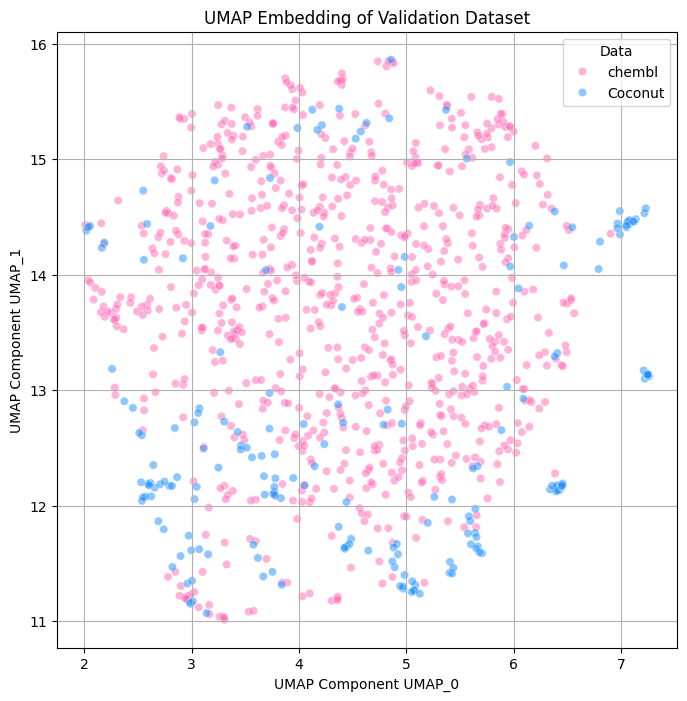

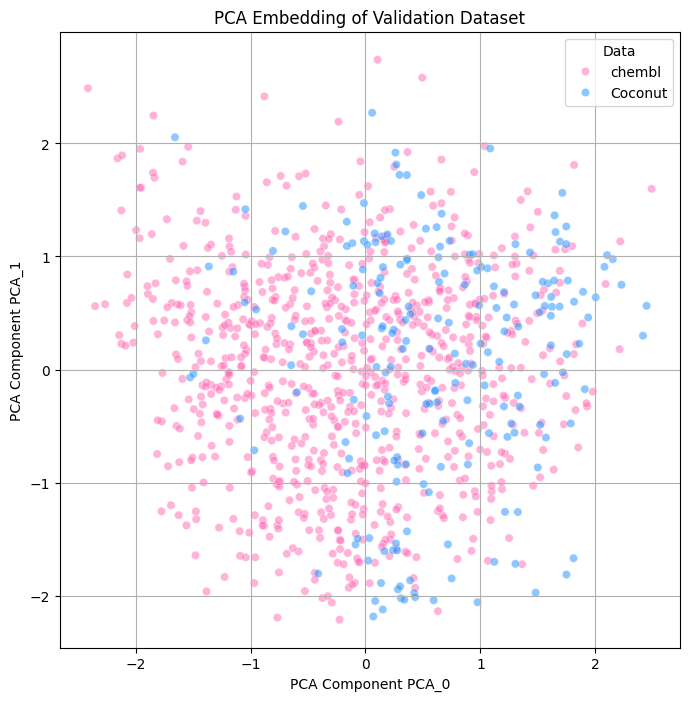

In [49]:
# Check column existence (adjust if needed)
!pip install seaborn
import seaborn as sns
permeable_col_name = 'Data'  # Assuming this is the correct column name for color mapping
umap_cols = ['UMAP_0', 'UMAP_1']
pca_cols = ['PCA_0', 'PCA_1']

if not all(col in combined_df.columns for col in umap_cols + pca_cols + [permeable_col_name]):
    raise ValueError(f"Missing some required columns: {set(umap_cols + pca_cols + [permeable_col_name]) - set(combined_df.columns)}")

# Create a color palette
palette = sns.color_palette(["hotpink", "dodgerblue"])

# Define methods and corresponding columns
methods = {
    "UMAP": umap_cols,
    "PCA": pca_cols
}

# Plot embeddings for each method
for method_name, (x_col, y_col) in methods.items():
    plt.figure(figsize=(8, 8))

    sns.scatterplot(
        data=combined_df,
        x=x_col,
        y=y_col,
        hue=permeable_col_name,
        alpha=0.5,
        palette=palette
    )

    plt.title(f"{method_name} Embedding of Validation Dataset")
    plt.xlabel(f"{method_name} Component {x_col}")
    plt.ylabel(f"{method_name} Component {y_col}")
    plt.grid(True)  # Add grid for visual clarity
    plt.show()
